In [1]:
!head $HOME/datasets/EMG/EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt

time	channel1	channel2	channel3	channel4	channel5	channel6	channel7	channel8	class
1	1e-05	-2e-05	-1e-05	-3e-05	0	-1e-05	0	-1e-05	0
5	1e-05	-2e-05	-1e-05	-3e-05	0	-1e-05	0	-1e-05	0
6	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
7	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
8	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
9	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
10	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
11	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0
12	-1e-05	1e-05	2e-05	0	1e-05	-2e-05	-1e-05	1e-05	0


In [2]:
import torch

torch.version.__version__

'1.13.0a0+git49444c3'

In [3]:
import os
from glob import glob
from tqdm.auto import tqdm
import numpy as np

def read_txt(filepath):
  x = []
  y = []
  with open(filepath, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[1:]):
      values = [float(val) for val in line.split('\t')]
      if len(values) != 10:
        continue
      x.append(values[:-1])
      y.append(int(values[-1]))
  assert len(x) == len(y)
  return x, y


def read_files():
  ROOT_FOLDER = os.path.join(os.getenv('HOME'), 'datasets', 'EMG', 'EMG_data_for_gestures-master')
  filepaths = glob(ROOT_FOLDER + '/**/*.txt')
  print('number of files: ', len(filepaths))

  X = []
  Y = []
  for filepath in tqdm(filepaths):
    x, y = read_txt(filepath)
    X += x
    Y += y
  return np.array(X).astype(np.float32), np.array(Y)


X, Y = read_files()
print('train X: ', X.shape)
print('train Y: ', Y.shape)

number of files:  72


  0%|          | 0/72 [00:00<?, ?it/s]

train X:  (4237907, 9)
train Y:  (4237907,)


There are 8 classes describe in README.txt:

Each file consist of 10 columns:

1 Time - time in ms;

2-9 Channel - eight EMG channels of MYO Thalmic bracelet

10 Class - the label of gestures: 

0. - unmarked data,
1. - hand at rest, 
2. - hand clenched in a fist, 
3. - wrist flexion,
4. - wrist extension,
5. - radial deviations,
6. - ulnar deviations,
7. - extended palm (the gesture was not performed by all subjects.

number of data points for class 0: (2725157, 8)
number of data points for class 1: (250055, 8)
number of data points for class 2: (243193, 8)
number of data points for class 3: (249494, 8)
number of data points for class 4: (251570, 8)
number of data points for class 5: (251733, 8)
number of data points for class 6: (253009, 8)
number of data points for class 7: (13696, 8)


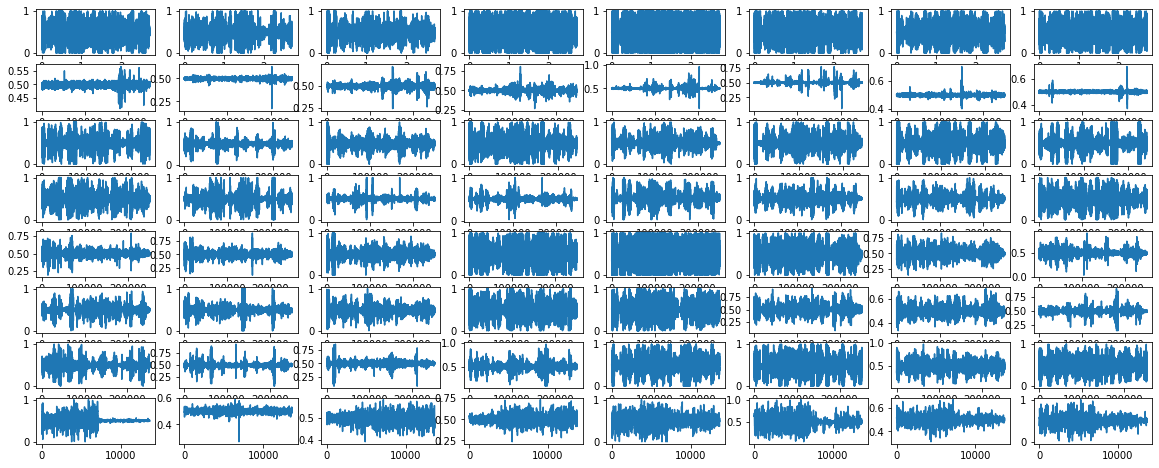

In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X[:, 1:])

def visualize_data(X, Y, num_classes):
  fig, axes = plt.subplots(num_classes, 8, figsize=(20, 8))
  for c in range(num_classes):
    index = Y == c
    x = X[index]

    print(f'number of data points for class {c}: {x.shape}')
    for i in range(8):
      axes[c][i].plot(x[:, i])


n_classes = 8
visualize_data(X, Y, n_classes)
plt.show()

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = 'cuda'

class EMGDataset(Dataset):
  def __init__(self, X, Y, num_classes=8, sequence_len=16, n_features=8):
    self.X = []
    self.Y = []
    for i, c in enumerate(range(num_classes)):
      index = Y == c
      x = X[index]
      y = Y[index]
      num_points = len(x)
      num_points = int(num_points // sequence_len * sequence_len)
      x = x[:num_points]
      x = x.reshape([-1, sequence_len, n_features])
      self.X.append(x)
      self.Y.append(np.full([len(x)], i))
      print(f'datapoints for {c}: {num_points}')

    self.X = np.concatenate(self.X)
    self.Y = np.concatenate(self.Y)

    self.X = torch.from_numpy(self.X)
    self.Y = torch.from_numpy(self.Y)
    self.X = self.X.to(device)
    self.Y = self.Y.to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]



sequence_len = 8
dataset_args = dict(
  num_classes=n_classes,
  sequence_len=sequence_len,
  n_features=8,
)


train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)
train_dataset = EMGDataset(train_x, train_y, **dataset_args)
test_dataset = EMGDataset(test_x, test_y, **dataset_args)
print('Train datasize: ', len(train_dataset))
print('Test datasize: ', len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

batch_size = 512
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, num_workers=num_workers, batch_size=batch_size)

datapoints for 0: 2180328
datapoints for 1: 200120
datapoints for 2: 194608
datapoints for 3: 199568
datapoints for 4: 201440
datapoints for 5: 201136
datapoints for 6: 202112
datapoints for 7: 10984
datapoints for 0: 544824
datapoints for 1: 49928
datapoints for 2: 48576
datapoints for 3: 49920
datapoints for 4: 50120
datapoints for 5: 50584
datapoints for 6: 50888
datapoints for 7: 2712
Train datasize:  423787
Test datasize:  105944
torch.Size([8, 8]) torch.Size([])


In [6]:
import torch.nn as nn

class ClickNet(nn.Module):
  def __init__(self, n_features, n_hidden, n_sequence, n_layers, n_classes, device):
    super(ClickNet, self).__init__()
    self.n_features = n_features
    self.n_hidden = n_hidden
    self.n_sequence = n_sequence
    self.n_layers = n_layers
    self.n_classes = n_classes
    self.device = device

    self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
    self.linear_1 = nn.Sequential(
      nn.Linear(in_features=n_hidden, out_features=64),
      nn.ReLU(),
    )
    self.dropout_1 = nn.Dropout(p=0.2)
    self.linear_2 = nn.Linear(in_features=64, out_features=n_classes)

  def forward(self, x):
    self.hidden = (
      torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(self.device),
      torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(self.device)
    )

    out, (hs, cs) = self.lstm(x.view(x.shape[0], self.n_sequence, -1), self.hidden)
    out = out[:,-1,:]
    out = self.linear_1(out)
    out = self.dropout_1(out)
    out = self.linear_2(out)
    return out



model_args = dict(
  n_features=8,
  n_hidden=64,
  n_sequence=sequence_len,
  n_layers=1,
  n_classes=n_classes,
  device=device
)
model = ClickNet(**model_args)
model.to(device)

sample_x, sample_y = next(iter(train_dataloader))
sample_x = sample_x.to(device)
sample_y = sample_y.to(device)
print(sample_x.shape)
y = model(sample_x)
print(y.shape)
print(sample_y.shape)

loss = nn.CrossEntropyLoss()
loss(y, sample_y)

torch.Size([512, 8, 8])
torch.Size([512, 8])
torch.Size([512])


tensor(2.1154, device='cuda:0', grad_fn=<NllLossBackward0>)

In [7]:
from torch.optim import Adam, SGD, AdamW


class Trainer(object):
  def __init__(self, model, train_dataloader, test_dataloader, lr=2e-4, num_epochs=600, device='cuda'):
    self.model = model
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.num_epochs = num_epochs
    self.device = device

    self.optimizer = AdamW(self.model.parameters(), lr=lr)
    self.loss_fn = nn.CrossEntropyLoss()

  def train_step(self):
    self.model.train()

    for x, y in train_dataloader:
      y_hat = self.model(x)

      loss = self.loss_fn(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  def train(self):
    for epoch in range(self.num_epochs):
      self.train_step()
      if (epoch+1) % 10 == 0:
        print(f'EPOCH: {epoch+1}')
        self.evaluate(self.train_dataloader, 'Train')
        self.evaluate(self.test_dataloader, 'Test')

  def evaluate(self, dataloader, dataset):
    self.model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    loss = 0
    correct = 0
    with torch.no_grad():
      for x, y in dataloader:
        pred = self.model(x)
        loss += self.loss_fn(pred, y).item()
        pred = pred.argmax(1)
        correct += (pred == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    print(f'{dataset} Accuracy: {correct}, loss: {loss}')


trainer = Trainer(model, train_dataloader, test_dataloader)
trainer.train()

EPOCH: 10
Train Accuracy: 0.6431084483478728, loss: 1.3032428170171912
Test Accuracy: 0.6428207354828966, loss: 1.3052840676284643
EPOCH: 20
Train Accuracy: 0.6497344184696557, loss: 1.1658630664797798
Test Accuracy: 0.6491542701804727, loss: 1.168466265650763
EPOCH: 30
Train Accuracy: 0.6529482971398367, loss: 1.052356100672685
Test Accuracy: 0.6524767801857585, loss: 1.055133199058293
EPOCH: 40
Train Accuracy: 0.6649094946281977, loss: 0.9697178527352891
Test Accuracy: 0.6636053009136903, loss: 0.9722778153592262
EPOCH: 50
Train Accuracy: 0.6892235958158226, loss: 0.9397149482642971
Test Accuracy: 0.6879011553273428, loss: 0.9417485380230318
EPOCH: 60
Train Accuracy: 0.6895445117476469, loss: 0.9228105731488426
Test Accuracy: 0.6885618817488485, loss: 0.9249599764600468
EPOCH: 70
Train Accuracy: 0.6965834251640565, loss: 0.8942004991470328
Test Accuracy: 0.695263535452692, loss: 0.8972332481888757
EPOCH: 80
Train Accuracy: 0.7021734975353184, loss: 0.8645149488811907
Test Accuracy: 0

In [8]:
model_checkpoint = './baseline.pt'

torch.save(model.state_dict(), model_checkpoint)

In [11]:
x = torch.randn(1, 8, 8, requires_grad=True)
x = x.to(device)

torch.onnx.export(
  model,                     # model being run
  x,                         # model input (or a tuple for multiple inputs)
  'baseline.onnx',           # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=11,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = ['input'],   # the model's input names
  output_names = ['output'], # the model's output names
  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                'output' : {0 : 'batch_size'}})